In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import ast

csv_path = "results/validation_predictions_with_texts_2.csv"

emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]



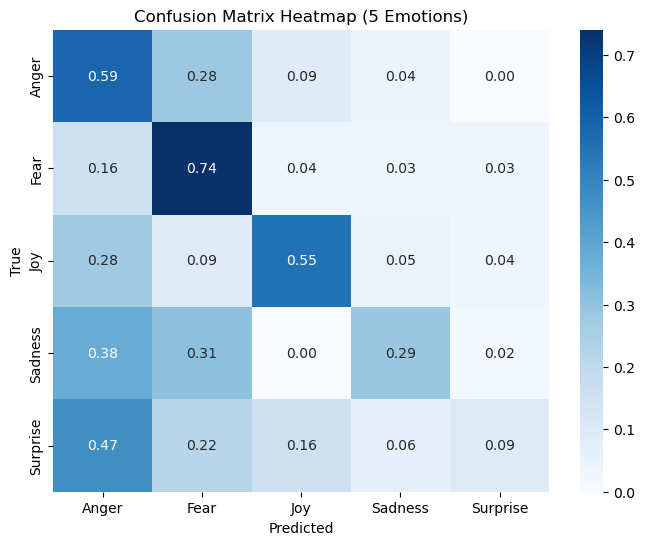

In [ ]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

# TODO: how to calculate for multi-class?
true_classes = true_labels.argmax(axis=1)
pred_classes = pred_labels.argmax(axis=1)

cm = confusion_matrix(true_classes, pred_classes, labels=range(len(emotion_labels)))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=emotion_labels, 
    yticklabels=emotion_labels
)
plt.title("Confusion Matrix Heatmap (5 Emotions)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
f1_scores = {
    emotion: f1_score(true_labels[:, i], pred_labels[:, i], average="binary")
    for i, emotion in enumerate(emotion_labels)
}

print("F1 Scores by Emotion:")
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score:.2f}")

average_f1 = np.mean(list(f1_scores.values()))
print(f"\nAverage F1 Score: {average_f1:.2f}")

F1 Scores by Emotion:
Anger: 0.44
Fear: 0.80
Joy: 0.61
Sadness: 0.65
Surprise: 0.55

Average F1 Score: 0.61


In [17]:
sum(df['True Labels'] == df['Predicted Labels']) / len(df)

0.41040462427745666

In [ ]:
DATA_PATH = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data/train/track_a/eng.csv"

all_data = pd.read_csv(DATA_PATH)

emotion_labels = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

class_distribution = all_data[emotion_labels].sum()
class_distribution

Anger        333
Fear        1611
Joy          674
Sadness      878
Surprise     839
dtype: int64

In [26]:
((all_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]==1).sum(axis=1)==1).sum()

1141

In [27]:
len(all_data)

2768

Idea: start training with one class only, fine tune with multi-class?